# Test and Visualize Results

In [110]:
import json
import ray
from ray import tune
from model import RNN,  Base
from utils import plot_data, get_input_data, get_dataloader
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

## Load files

In [70]:
DATA_DIM = 2
MODEL_NAME = "LSTM"

In [79]:
log_file_name = os.listdir(os.path.join("./logs", f'experiments_{DATA_DIM}D', MODEL_NAME))[0]
log_file_path = os.path.join("./logs", f'experiments_{DATA_DIM}D', MODEL_NAME, log_file_name)
MODEL_NAME = "LSTM"

log_file_path

'./logs/experiments_2D/LSTM/best_config_generated_data_fbcampus_2.json'

In [72]:
# best configuration
with open(log_file_path, 'r') as fp:
    best_config = json.load(fp)

best_config

{'dir': '/home/anees.hashmi/ray_results/train_ray_2023-04-30_05-02-51/train_ray_bdf52_00011_11_lr=0.0004,num_layers=2,sequence_length=28_2023-04-30_05-08-48',
 'hidden_size': 256,
 'lr': 0.00041781191030030137,
 'metric': 11.07781400680542,
 'num_layers': 2,
 'sequence_length': 28}

In [73]:
CHECKPOINT_DIR = best_config['dir']
chkpoints_list = [i for i in os.listdir(CHECKPOINT_DIR) if i.startswith("checkpoint")]
last_checkpoint = sorted(chkpoints_list, key=lambda x: int(x.split('_')[-1]))[-1]

last_checkpoint

'checkpoint_000099'

In [100]:
model = Base(input_size=9 if DATA_DIM == 1 else 18, 
             hidden_size = best_config["hidden_size"],
             num_layers = best_config["num_layers"],
            #  sequence_length=model_config['sequence_length'],
             output_size=1 if DATA_DIM == 1 else 3,
             model = MODEL_NAME)

In [101]:
chkpoint_state_dict, optim_state = torch.load(os.path.join(CHECKPOINT_DIR, f'{last_checkpoint}', "checkpoint"))

In [102]:
model.load_state_dict(chkpoint_state_dict)

<All keys matched successfully>

In [103]:
EVAL_DATA_DIR = '/home/anees.hashmi/Desktop/kalmanfilters_nn/data/2D/evaluation_data/fbcampus_alpha_4_run_2_merged.csv'

params = {
        "batch_size": 100,
        "model_name": MODEL_NAME,
        "input_size": 18 if DATA_DIM == 2 else 9,
        "output_size": 3 if DATA_DIM == 2 else 1,
    }
params

{'batch_size': 100, 'model_name': 'LSTM', 'input_size': 18, 'output_size': 3}

In [104]:
X = get_input_data(seq_len = best_config['sequence_length'], 
                   batch_size = params['batch_size'], datadir=EVAL_DATA_DIR)

In [105]:
type(X), len(X), X[0].shape, X[1].shape

(tuple, 5, (2800, 28, 18), (2800, 3))

In [106]:
test_loader = get_dataloader(X[0], X[1], batch_size=params['batch_size'])


In [107]:
def test_accuracy(net, test_loader, device="cpu"):
    
    net.to(device)
    criterion = nn.MSELoss()
    loss = 0
    total = 0
    test_pred = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs, _ = net(input)
            # _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            loss += criterion(outputs, labels).cpu().numpy()
            test_pred.append(outputs.cpu().numpy())
    return loss / total, test_pred


In [108]:
loss, test_pred = test_accuracy(model, test_loader, device='cpu')

In [109]:
loss

0.9011482188531331

In [116]:
# np.stack(test_pred).shape
next(iter(test_loader))[0].shape, next(iter(test_loader))[1].shape

(torch.Size([100, 28, 18]), torch.Size([100, 3]))

In [120]:
test_pred = np.concatenate(test_pred, axis=0)
test_pred.shape

(2800, 3)

In [125]:
kalman_pred = X[2]
kalman_pred.shape

(2800, 3)

In [127]:
criterion = nn.MSELoss()

In [131]:
print(f"MSE for {MODEL_NAME} is {criterion(torch.tensor(test_pred), torch.tensor(X[1])).item()}")
print(f"MSE for Kalman Filter is {criterion(torch.tensor(kalman_pred), torch.tensor(X[1])).item()}")

MSE for LSTM is 90.11482239632224
MSE for Kalman Filter is 174.0953148865049


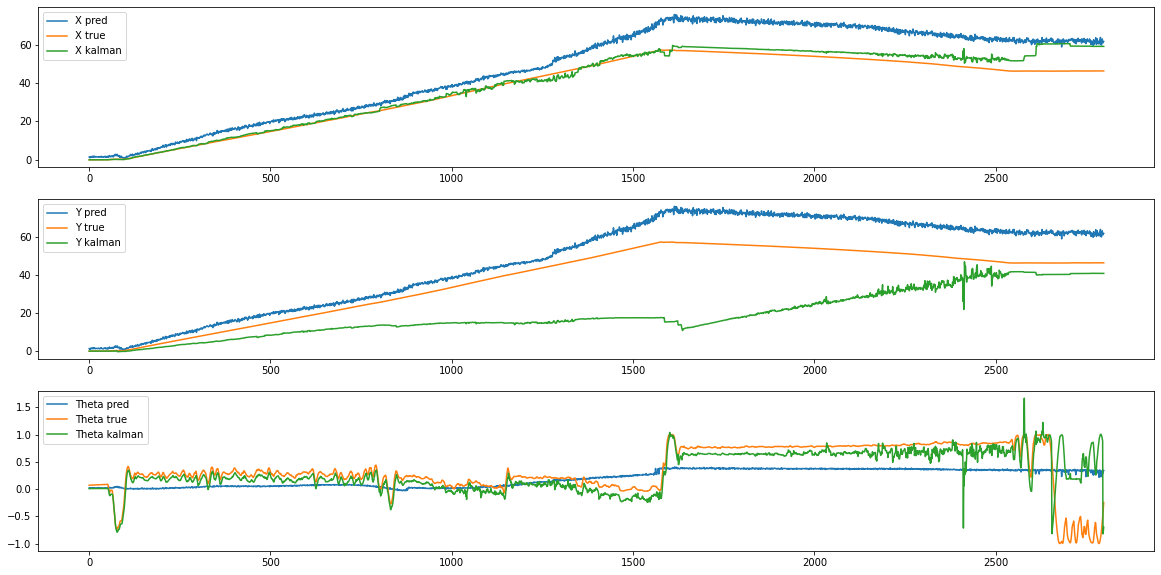

In [132]:
lim = -1

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(test_pred[:lim, 0], label='X pred')
plt.plot(X[1][:lim, 0], label='X true')
plt.plot(kalman_pred[:lim, 0], label='X kalman')
plt.legend(['X pred', 'X true', 'X kalman'])

plt.subplot(3, 1, 2)
plt.plot(test_pred[:lim, 1], label='Y pred')
plt.plot(X[1][:lim, 1], label='Y true')
plt.plot(kalman_pred[:lim, 1], label='Y kalman')
plt.legend(['Y pred', 'Y true', 'Y kalman'])

plt.subplot(3, 1, 3)
plt.plot(test_pred[:lim, 2], label='Theta pred')
plt.plot(X[1][:lim, 2], label='Theta true')
plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
plt.legend(['Theta pred', 'Theta true', 'Theta kalman'])

# plt.legend()
plt.show()
